In [10]:
from generator.context import SNVGeneratorContext
from generator.model import SNVModel, CellData
from generator.gen_utils import sample_conditionally_with_replacement

from typing import List, Tuple
import numpy as np
import random

In [13]:
class GeneratorContext(SNVGeneratorContext):
    def get_epsilon(self) -> float:
        """
        Prawdopodobienstwo alternatywnego readu, jezeli nie ma mutacji 
        """
        return 0.05

    def get_total_number_of_reads(self) -> int:
        return 100000

    def get_per_allele_coverage(self) -> float:
        return 0.05

    def get_neutral_cn(self) -> int:
        return 2

    def sample_cn_change(self, event: Tuple[int, int], parent_cn_profile: np.ndarray, overlap_bit_map: np.ndarray) -> int:
        """
            Wyznaczanie zmiany CN przez wydarzenie @event.
            parent_cn_profile - tablica (dlugosc to ilosc binow) trzymajaca CN profile rodzica w drzewie
            overlap_bit_map - tablica (dlugosc to ilosc binow) 0, 1, gdzie oberlap_bit_map[bin] == 1.0 
            oznacza, ze bin jest objety jakims wydarzeniem w potomku wierzcholka @event - a wiec nie moze 
            byc na tym binie calkowitej delecji.
        
        """
        if np.sum(overlap_bit_map) == 0.0: # No bin is present in child nodes- we can do full deletion
            return sample_conditionally_with_replacement(1, lambda: random.randint(-int(np.min(parent_cn_profile)), 2), lambda x: x != 0)[0]

        min_cn_in_bins_with_overlap = np.min(parent_cn_profile[overlap_bit_map == 1.0])
        max_possible_deletion = -min(2, int(min_cn_in_bins_with_overlap) - 1)
        return sample_conditionally_with_replacement(1, lambda: random.randint(max_possible_deletion, 2), lambda x: x != 0)[0]


    def get_number_of_bins(self) -> int:
        return 1000

    def get_cn_event_candidates(self) -> List[Tuple[int, int]]:
        return [(a, b) for a in range(0, 1000) for b in range(0, 1000) if a < b and b - a < 50]

    def get_snv_event_candidates(self) -> List[int]:
        """
        Lista wszystkich mozliwych SNV, mamy jeden SNV per bin, wiec SNV reprezentujemy przez nr bin
        """
        return [i for i in range(0, 1000)]

    def sample_number_of_snvs_for_edge(self, num_available_snvs: int) -> int:
        """
            Losowanie ilosci SVN na krawedzi.
            @num_available_snvs = Ile jest dostepnych SNV 
        """
        return min(num_available_snvs, np.random.poisson(lam=1.0, size=None))

    def get_number_of_alterations(self, cn_before: int, cn_after: int) -> int:
        """
            Ile zmutowanych kopii ma byc w binie, ktory przed mutacja mial @cn_before CN, przeszedl mutacje, 
            a nastepnie zmiane CN do @cn_after. 
            
            Na razie jest tak, ze jezeli cn_after > cn_before, to z prawdopodobienstwem 1 / cn_before wszystkie nowe 
            kopie maja mutacje (i jedna zmutowana, z ktorej te nowe sie wziely), przeciwnie tylko 1.
            
            Jezeli cn_after < cn_before to z prawdopodobienstwem cn_after / cn_before 1 przeciwnie 0 (bo kopia z mutacja 
            zostala usunieta)
            
        """
        if cn_after == cn_before:
            return 1
        elif cn_after > cn_before:
            return 1 if random.randint(0, cn_before) > 0 else cn_after - cn_before + 1
        else:
            return 1 if random.randint(0, cn_before) < cn_after else 0

In [42]:
model = SNVModel(GeneratorContext())
model.generate_structure(10)

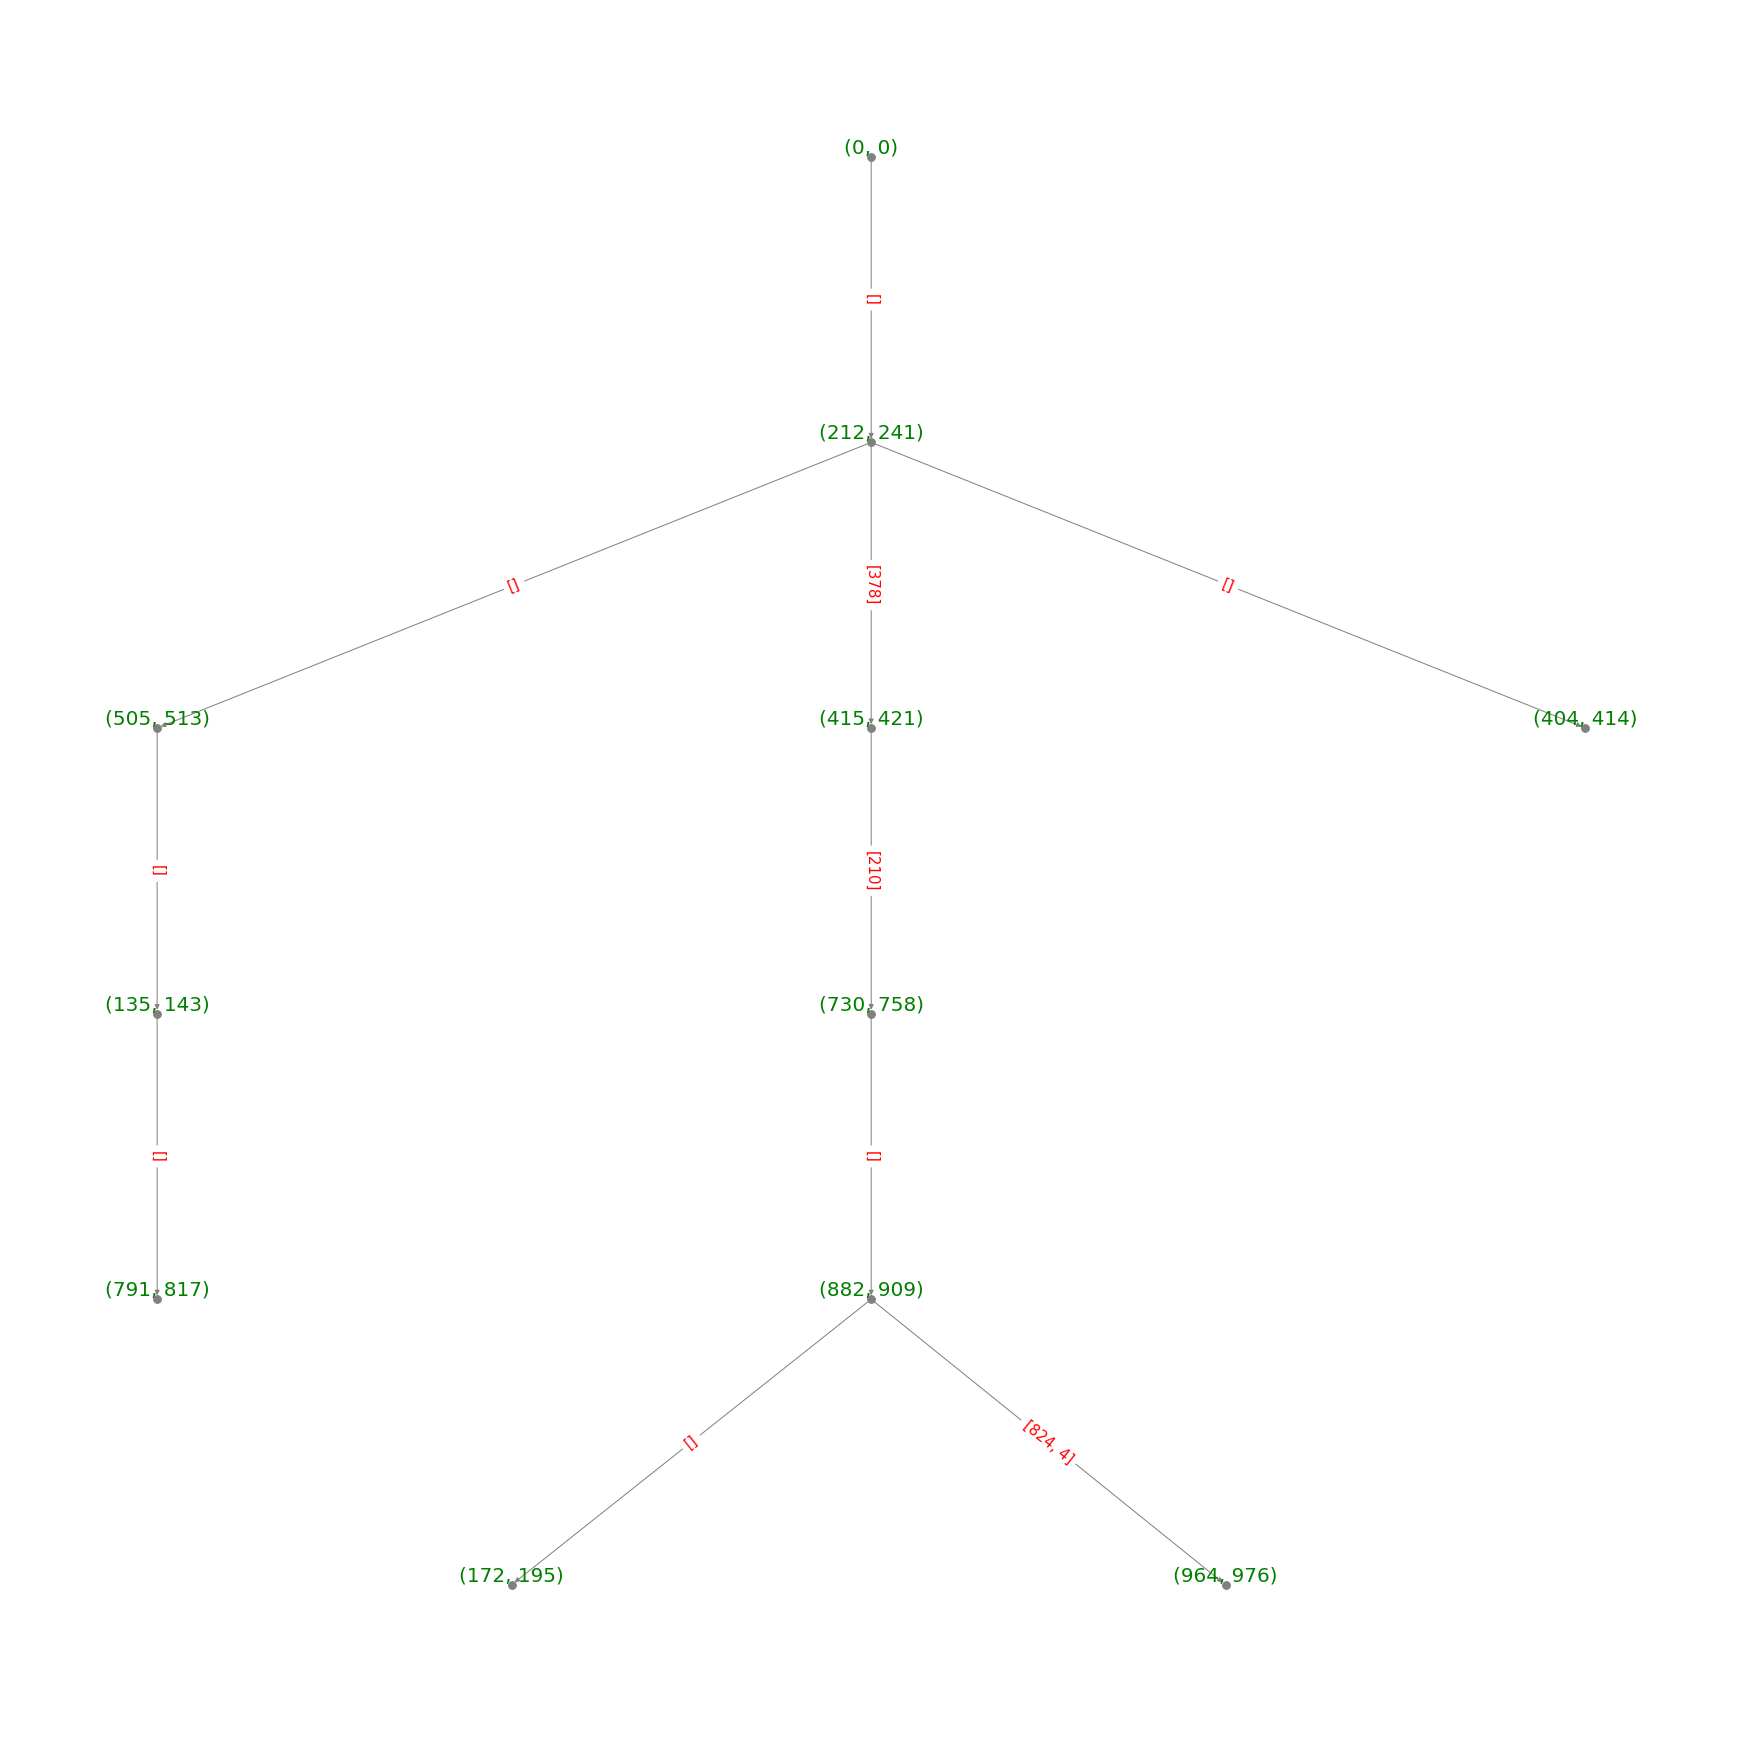

In [43]:
"""
DRAW TREE + SNVs 
"""

from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx 
import json
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(model.event_tree.cn_event_tree, prog="dot")
nx.draw(model.event_tree.cn_event_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")


edge_dict = {} 
for edge in model.event_tree.cn_event_tree.edges: 
    edge_dict[edge] = json.dumps(list(model.event_tree.node_to_snvs[edge[1]]))
nx.draw_networkx_edge_labels(
    model.event_tree.cn_event_tree, pos,
    edge_labels=edge_dict,
    font_color='red', font_size = 15
)
plt.show()

In [44]:
"""
sample cell:
"""
cell_data: CellData = next(model.generate_cell())

In [45]:
cell_data.d

array([ 905380.,  903293.,  899721.,  899016.,  895575.,  901679.,
        900508.,  899123.,  903994.,  901103.,  896558.,  896622.,
        901247.,  900091.,  897891.,  904936.,  899313.,  896084.,
        898077.,  903291.,  899142.,  901126.,  901410.,  903083.,
        896356.,  898096.,  905392.,  899226.,  904977.,  900061.,
        899565.,  896381.,  903061.,  905340.,  901136.,  899314.,
        891443.,  905005.,  898905.,  901706.,  910383.,  898756.,
        900433.,  900254.,  895808.,  898240.,  897792.,  899735.,
        896488.,  899694.,  899490.,  901846.,  905160.,  900688.,
        901134.,  896847.,  891654.,  903226.,  898580.,  901570.,
        904676.,  901355.,  895613.,  899343.,  901807.,  899255.,
        899015.,  900211.,  901442.,  900219.,  900681.,  896953.,
        902518.,  903041.,  899352.,  898344.,  898421.,  896609.,
        902528.,  899596.,  894040.,  903791.,  898803.,  899881.,
        901340.,  900923.,  902198.,  891532.,  903883.,  8934

In [46]:
cell_data.b

array([ 45300.,  45513.,  44817.,  45144., 447821.,  44989.,  44882.,
        44936.,  45223.,  44839.,  45443.,  44797.,  45123.,  45109.,
        44853.,  45168.,  44991.,  45127.,  44757.,  45312.,  44790.,
        44532.,  45142.,  44860.,  44891.,  45313.,  45213.,  45029.,
        44982.,  44957.,  44645.,  44870.,  45191.,  45379.,  45389.,
        44838.,  44485.,  45617.,  44647.,  45305.,  45429.,  44891.,
        44951.,  45300.,  45045.,  45176.,  44999.,  45046.,  44629.,
        45181.,  44941.,  44805.,  44845.,  45119.,  45169.,  44952.,
        44277.,  44737.,  44876.,  45074.,  44899.,  45009.,  44835.,
        44842.,  45130.,  44550.,  44865.,  45412.,  44979.,  45275.,
        45386.,  44735.,  44937.,  44971.,  44807.,  44952.,  45100.,
        44713.,  44904.,  44866.,  44651.,  45024.,  44958.,  44905.,
        45121.,  45250.,  45139.,  44350.,  45020.,  44916.,  45406.,
        44768.,  44688.,  45007.,  45064.,  45099.,  45209.,  44563.,
        44792.,  449

In [47]:
"""
Real cell CN profile:
"""
model.node_to_cn_profile[cell_data.attachment]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,